# Исследование воронки продаж продуктов питания #

# Описание проекта

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 

Для этого изучим воронку продаж. Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, мы можем быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

В случае общей аналитики и A/A/B-эксперимента работаем с одними и теми же данными.

**Описание данных**

- *EventName* — название события;
- *DeviceIDHash* — уникальный идентификатор пользователя;
- *EventTimestamp* — время события;
- *ExpId* — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

Каждая запись в логе — это действие пользователя, или событие. 

## 1 шаг. Откроем файл с данными и изучим общую информацию

In [1]:
#импорт библиотек
import pandas as pd
from datetime import datetime as dt, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math as mth
import plotly.express as px

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')
display(data.head(10))

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Количество значений в столбцах одинаково, значит пропусков нет.

## 2 шаг. Подготовка данных

- Изменим названия столбцов

In [4]:
data = data.rename(columns = {'EventName': 'event_name', 'DeviceIDHash': 'user_id', 'EventTimestamp': 'event_timestamp', 
                              'ExpId': 'exp_id'})
data.head()#проверка

,event_name,user_id,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


- Преобразуем тип данных в столбце с датой и создадим новый столбец

In [5]:
data['event_time'] = pd.to_datetime(data['event_timestamp'], unit='s')
data.head()

,event_name,user_id,event_timestamp,exp_id,event_time
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42


In [6]:
data.info()#проверка

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       244126 non-null  object        
 1   user_id          244126 non-null  int64         
 2   event_timestamp  244126 non-null  int64         
 3   exp_id           244126 non-null  int64         
 4   event_time       244126 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 9.3+ MB


- Добавим столбец только с датой без времени

In [7]:
data['event_day'] = data['event_time'].dt.date #оставляем только дату
data.head()

,event_name,user_id,event_timestamp,exp_id,event_time,event_day
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [8]:
data['event_day'] = pd.to_datetime(data['event_day']) #меняем тип данных на datetime

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       244126 non-null  object        
 1   user_id          244126 non-null  int64         
 2   event_timestamp  244126 non-null  int64         
 3   exp_id           244126 non-null  int64         
 4   event_time       244126 non-null  datetime64[ns]
 5   event_day        244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


- Проверим, есть ли в данных дубликаты:

In [10]:
print('Всего дубликатов:', data.duplicated().sum())
print('Доля дубликатов от общего числа событий', round(data.duplicated().sum()/data['user_id'].count(), 4))

Всего дубликатов: 413
Доля дубликатов от общего числа событий 0.0017


Обнаружили 413 дубликатов, что составляет всего лишь 00,17% от всех пользователей, поэтому можем их удалить (они могли возникнуть из-за технической ошибки).

In [11]:
data = data.drop_duplicates()
data.duplicated().sum() #проверка

0

- Проверим, есть ли пересечения среди групп:

In [12]:
cross = data.groupby('user_id').agg({'exp_id':'nunique'})
cross = cross[cross['exp_id'] > 1]
print(cross.shape)

(0, 1)


Пересечений не обнаружили.

## 3 шаг. Изучим и проверим данные 

- Сколько всего событий в логе?

In [13]:
event_name_count = data['event_name'].nunique()
print('Всего событий в логе:', event_name_count)

Всего событий в логе: 5


In [14]:
event_name_which = data['event_name'].unique()
print(event_name_which)

['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']


У нас всего 5 событий: MainScreenAppear - появление главного экрана, PaymentScreenSuccessful - экран с подтверждением платежа, CartScreenAppear - экран корзины, OffersScreenAppear - экран предложений, Tutorial - экран с обучением (тут не уверена с переводом).

- Сколько всего пользователей в логе?

In [15]:
user_count = data['user_id'].nunique()
print('Всего пользователей в логе:', user_count)

Всего пользователей в логе: 7551


- Сколько в среднем событий приходится на пользователя?

In [16]:
avg_event = round(data['event_name'].count()/user_count)
print(avg_event, 'события в среднем приходится на пользователя.')

32 события в среднем приходится на пользователя.


- Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?

In [17]:
day_min = data['event_day'].min()
day_max = data['event_day'].max()
print(day_min, day_max)

2019-07-25 00:00:00 2019-08-07 00:00:00


Мы имеем данные начиная с 25 июля 2019 года по 7 августа 2019 года.

Построим гистограмму по дате и времени.

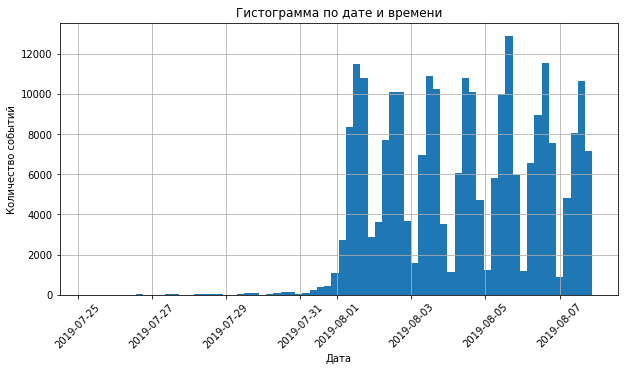

In [18]:
data.hist('event_time', bins = 70,  figsize=(10, 5))

plt.title('Гистограмма по дате и времени')
plt.xticks(rotation=45)
plt.xlabel('Дата') 
plt.ylabel('Количество событий');

Мы не можем быть уверенными, что у вас одинаково полные данные за весь период. С 25 июля по 31 июля мы получали крайне мало данных, чтобы суметь их правильно проанализировать. Дейстительно мы располагаем данными лишь за первую неделю августа. 

In [19]:
#исключим данные за период 25 июля - 31 июля
data_new = data[(data['event_day']>'2019-07-31')]
day_min = data['event_day'].min()
print(day_min)

2019-07-25 00:00:00


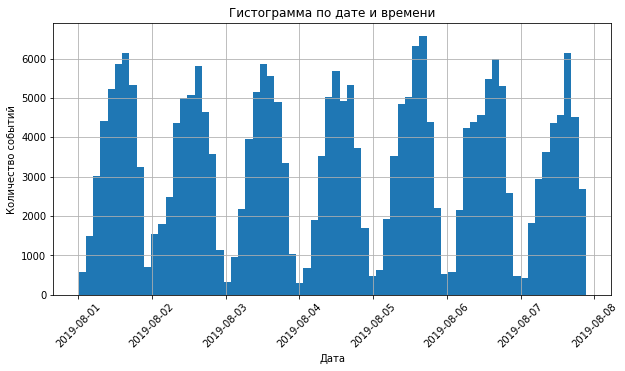

In [20]:
data_new.hist('event_time', bins = 70,  figsize=(10, 5))
plt.title('Гистограмма по дате и времени')
plt.xticks(rotation=45)
plt.xlabel('Дата') 
plt.ylabel('Количество событий');

По гистограмме видно, что пользователи в основном посещают мобильное приложение в дневное время.

- Много ли событий и пользователей вы потеряли, отбросив старые данные?

Проверим какой процент событий мы отсеяли:

In [21]:
event_del = (data['event_time'].count()-data_new['event_time'].count())/data['event_time'].count()
print(f'{(event_del):.2%} событий отсеяли.')

1.16% событий отсеяли.


Отсеяли чуть больше 1 процента.

Сколько пользователей потеряли:

In [22]:
users_count_new = data_new['user_id'].nunique() #кол-во пользователей после удаления данных

print(f'{((user_count-users_count_new)/user_count):.2%} пользователей потеряли')

0.23% пользователей потеряли


Потеряли меньше 1 процента.

Доля отсеяных пользователей и событий мала, поэтому не повнияет на результаты эксперимента. 

- Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

In [23]:
data_new.groupby('exp_id')['user_id'].agg('nunique')

exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

Есть пользователи из всех трех экспериментальных групп и их количество примерно одинаково.

In [24]:
data = data_new #переименуем таблицу с данными

## 4  шаг. Изучите воронку событий

- Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.

In [25]:
events = data.groupby('event_name')['user_id'].agg('count')
events = pd.DataFrame(events).sort_values(by = 'user_id', ascending = False)
events = events.rename(columns = {'user_id': 'count_event'})
events

,count_event
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


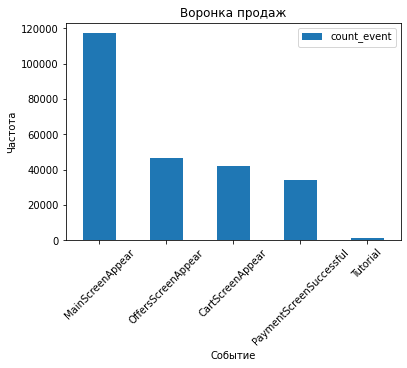

In [26]:
events.plot(kind='bar', title = 'Воронка продаж');
plt.xticks(rotation=45)
plt.xlabel('Событие') 
plt.ylabel('Частота');

Наиболее часто встречается событие 'Появление главного экрана'

- Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.

Добавим в таблицу event_name долю пользователей, которые хоть раз совершали это событие:

In [27]:
count_user = data['user_id'].nunique() #всего уникальных пользователей
#print(count_user)
events['user_id'] = data.groupby('event_name')['user_id'].agg('nunique') #кол-во уникальных пользователей в каждом событии

events['user_share'] = round(events['user_id']/count_user, 2)
events

,count_event,user_id,user_share
event_name,,,
MainScreenAppear,117328,7419,0.98
OffersScreenAppear,46333,4593,0.61
CartScreenAppear,42303,3734,0.50
PaymentScreenSuccessful,33918,3539,0.47
Tutorial,1005,840,0.11


Видим, что первый экран хотя бы раз посетили 0.98 пользователей, этот показатель не 1, те некоторые пользователи могли сразу переходить на другие экраны по сторонней ссылке. Самый маленький показатель составил 0.11 у Tutorial.

- Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

Цепочка для большинства пользователей: MainScreenAppear => OffersScreenAppear => CartScreenAppear => PaymentScreenSuccessful

Tutorial, я считаю, что открывают вне цепочки, когда пользователи что-то не понятно о работе приложения.

- По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [28]:
events['funnel'] = events['user_id']/events['user_id'].shift(1)
events = events.drop(['Tutorial'], axis = 0) #удалим строку Tutorial, тк она не входит в воронку
events

,count_event,user_id,user_share,funnel
event_name,,,,
MainScreenAppear,117328,7419,0.98,NaN
OffersScreenAppear,46333,4593,0.61,0.619086
CartScreenAppear,42303,3734,0.50,0.812976
PaymentScreenSuccessful,33918,3539,0.47,0.947777


- На каком шаге теряете больше всего пользователей?

Больше всего пользователей теряем при переходе с главного экрана на экран предложения. Меньше всего при оплате.

- Какая доля пользователей доходит от первого события до оплаты?

In [29]:
print(round(events['user_id']['PaymentScreenSuccessful']/events['user_id']['MainScreenAppear'], 2), 
      '- доля пользователей дошедших от первого события до оплаты' )



0.48 - доля пользователей дошедших от первого события до оплаты


## 5 шаг. Изучите результаты эксперимента

- Сколько пользователей в каждой экспериментальной группе? 

In [30]:
exp_an = data.groupby('exp_id')['user_id'].agg('nunique')
exp_an = pd.DataFrame(exp_an)
exp_an

,user_id
exp_id,
246,2484
247,2513
248,2537


В каждой группе примерно 2500 пользователей.

- Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.

Сравним конверсии между выборками 246 и 247. Для начала узнаем, сколько пользователей в каждой группе посетило главный экран и сколько пользователей в каждой группе дошли до окна с успешной оплатой:

In [31]:
total_246 = data.query("exp_id == 246 & event_name == 'MainScreenAppear'")['user_id'].nunique()
total_247 = data.query("exp_id == 247 & event_name == 'MainScreenAppear'")['user_id'].nunique()
pay_246 = data.query("exp_id == 246 & event_name == 'PaymentScreenSuccessful'")['user_id'].nunique()
pay_247 = data.query("exp_id == 247 & event_name == 'PaymentScreenSuccessful'")['user_id'].nunique()
#print(pay_246, pay_247)

Посмотрим равна ли конверсия выборок 246 и 247 с помошью z-теста для долей сравнив доли пользователей из каждой группы. За критический уровень статистической значимости примем alpha = .05.

Н0: Доли пользователей, сделавших заказ в обоих группах одинаковы.

Н1: Доли пользователей, сделавших заказ в обоих группах разные.

In [32]:
alpha = .05 # критический уровень статистической значимости

successes = np.array([pay_246, pay_247])
trials = np.array([total_246, total_247])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

In [33]:
# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 

Если бы пропорции были равны, разница между ними была бы равна нулю. Посчитаем, как далеко статистика уехала от нуля. Какова вероятность получить такое отличие или больше?

In [34]:
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.12044299485641763
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Вывод: между выборками 246 и 247 нет статистически значимых различий.

- Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

Самое популярное событие: MainScreenAppear.

Число пользователей совершившее событие MainScreenAppear в каждой из контрольных групп (сюда же добавила и экспериментальную, чтобы не делать отдельную таблицу со всеми тремя группами):

In [35]:
exp_an['user_id_main'] = data.query("event_name == 'MainScreenAppear'").groupby('exp_id')['user_id'].agg('nunique')
exp_an

,user_id,user_id_main
exp_id,,
246,2484,2450
247,2513,2476
248,2537,2493


Доля пользователей, посетивших главный экран от общего числа пользователей:

In [36]:
exp_an['user_id_main_share'] = round(exp_an['user_id_main']/exp_an['user_id'], 2)
exp_an

,user_id,user_id_main,user_id_main_share
exp_id,,,
246,2484,2450,0.99
247,2513,2476,0.99
248,2537,2493,0.98


Доля пользователей совершивших это событие примерно одинакова.

Проверим, будет ли отличие между группами статистически достоверным.

Н0: Доли пользователей, перешедших на первый экран в обоих группах равны.

Н1: Доли пользователей, перешедших на первый экран в обоих группах не равны.

In [37]:
alpha = .05 # критический уровень статистической значимости

successes = np.array([exp_an['user_id_main'][246], exp_an['user_id_main'][247]])
trials = np.array([exp_an['user_id'][246], exp_an['user_id'][247]])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Доли пользователей посетивших главный экран одинаковы.

Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?


Н0: Доли пользователей обоих группах равны

Н1: Доли пользователей обоих группах не равны

In [38]:
def z_test(alpha, total_1, total_2, n1, n2):
    alpha = alpha # критический уровень статистической значимости

    successes = np.array([n1, n2])
    trials = np.array([total_1, total_2])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2


    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
         print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )


Сделаем общую таблицу для проведения z-теста для долей:

In [39]:
total_ex = exp_an.drop(['user_id_main_share'], axis = 1)
total_ex['user_id_off'] = data.query("event_name == 'OffersScreenAppear'").groupby('exp_id')['user_id'].agg('nunique')
total_ex['user_id_cart'] = data.query("event_name == 'CartScreenAppear'").groupby('exp_id')['user_id'].agg('nunique')
total_ex['user_id_pay'] = data.query("event_name == 'PaymentScreenSuccessful'").groupby('exp_id')['user_id'].agg('nunique')
total_ex

,user_id,user_id_main,user_id_off,user_id_cart,user_id_pay
exp_id,,,,,
246,2484,2450,1542,1266,1200
247,2513,2476,1520,1238,1158
248,2537,2493,1531,1230,1181


Проведем z-тест для проверки статистически значимых различий для переходов к OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful:

In [40]:
column_title = total_ex.columns.values.tolist()
print(column_title)

['user_id', 'user_id_main', 'user_id_off', 'user_id_cart', 'user_id_pay']


In [41]:
column_dict = {'user_id_off': 'OffersScreenAppear', 'user_id_cart': 'CartScreenAppear', 'user_id_pay': 'PaymentScreenSuccessful'}

for column in column_dict:
    print(f'Для переходов к {column_dict[column]}:')
    z_test(.05, total_ex['user_id'][246], total_ex['user_id'][247], total_ex[column][246], total_ex[column][247])
    print('')

Для переходов к OffersScreenAppear:
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для переходов к CartScreenAppear:
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для переходов к PaymentScreenSuccessful:
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Приходим к выводу, что выборки 246 и 247 статистически равны и разбиение на группы работает корректно.

- Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

z-тест для долей для групп 246 и 248:

In [42]:
column_dict = {'user_id_main': 'MainScreenAppear', 'user_id_off': 'OffersScreenAppear', 'user_id_cart': 'CartScreenAppear', 'user_id_pay': 'PaymentScreenSuccessful'}

for column in column_dict:
    print(f'Для переходов к {column_dict[column]}:')
    z_test(.05, total_ex['user_id'][246], total_ex['user_id'][248], total_ex[column][246], total_ex[column][248])
    print('')

Для переходов к MainScreenAppear:
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для переходов к OffersScreenAppear:
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для переходов к CartScreenAppear:
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для переходов к PaymentScreenSuccessful:
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



z-тест для долей для групп 247 и 248:

In [43]:
column_dict = {'user_id_main': 'MainScreenAppear', 'user_id_off': 'OffersScreenAppear', 'user_id_cart': 'CartScreenAppear', 'user_id_pay': 'PaymentScreenSuccessful'}

for column in column_dict:
    print(f'Для переходов к {column_dict[column]}:')
    z_test(.05, total_ex['user_id'][247], total_ex['user_id'][248], total_ex[column][247], total_ex[column][248])
    print('')

Для переходов к MainScreenAppear:
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для переходов к OffersScreenAppear:
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для переходов к CartScreenAppear:
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для переходов к PaymentScreenSuccessful:
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



z-тест для долей для объедененной контрольной группы и 248:

In [44]:
column_dict = {'user_id_main': 'MainScreenAppear', 'user_id_off': 'OffersScreenAppear', 'user_id_cart': 'CartScreenAppear', 'user_id_pay': 'PaymentScreenSuccessful'}

for column in column_dict:
    print(f'Для переходов к {column_dict[column]}:')
    z_test(.05, total_ex['user_id'][246]+total_ex['user_id'][247], total_ex['user_id'][248], total_ex[column][246]+total_ex[column][247], total_ex[column][248])
    print('')

Для переходов к MainScreenAppear:
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для переходов к OffersScreenAppear:
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для переходов к CartScreenAppear:
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для переходов к PaymentScreenSuccessful:
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Конверсия пользователей у группы с измеренным шрифтом от группы до апгрейта не изменилась, суммирование контрольных групп не привело к измерению результатов.

- Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

При проверке статистических гипотез выше был выбран уровень статистической значимости равным alpha = .05. Всего было сделано 17 проверок статистических гипотез. При моем уровне значимости каждый  20 раз можно получать ложный результат, таким образом результаты теста будут достовернее. 

## Вывод: 

В ходе работы изучили воронку продаж. Путь до покупки у большинства пользователей имеет следующий вид: MainScreenAppear => OffersScreenAppear => CartScreenAppear => PaymentScreenSuccessful. Доля пользователей дошедших от первого события до оплаты составила 0.48. Больше всего пользователей теряем при переходе с главного экрана на экран предложения. Меньше всего при оплате.

Для исследования A/A/B-эксперимента провели z-тест для проверки статистически значимых различий для переходов к OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessfu. В рузельтате пришли к выводу, что изменение шрифта не повлияло на конверсию пользователей.